## EX 04: Portrait Mode 구현
---

## Step 1 인물모드 직접 해 보기

### 1-1. 이미지 불러오기

In [43]:
#라이브러리 불러오기

import os

import urllib

import cv2

import numpy as np

from pixellib.semantic import semantic_segmentation

from matplotlib import pyplot as plt

In [44]:
#이미지 불러오기

#os.getenv()통해 홈 디렉토리 가져오고, 이후 공통적인 경로 더해주기
img_dir = os.getenv('HOME') + '/aiffel/AIFFEL_quest_rs/Exploration/Ex04/images'

#os.path.join이용해서 각 이미지 경로 만들어 주기
img_path_me = os.path.join(img_dir, "me.jpg")
img_path_cat = os.path.join(img_dir, "cat.jpg")
img_path_bg = os.path.join(img_dir, "bg.jpg")

me = cv2.imread(img_path_me)
cat = cv2.imread(img_path_cat)
bg = cv2.imread(img_path_bg)

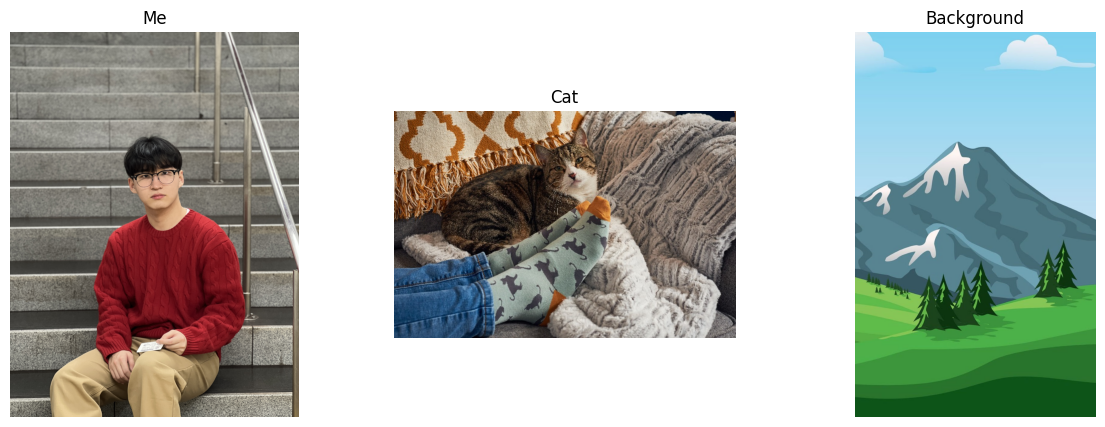

In [45]:
# 1행 3열의 서브 플롯 생성
fig, axes = plt.subplots(1, 3, figsize=(15, 5)) 

#BGR에서 RGB로 채널 변경하고 출력하기
axes[0].imshow(cv2.cvtColor(me, cv2.COLOR_BGR2RGB))
axes[0].set_title("Me")
axes[0].axis("off")  # 축 제거

axes[1].imshow(cv2.cvtColor(cat, cv2.COLOR_BGR2RGB))
axes[1].set_title("Cat")
axes[1].axis("off")

axes[2].imshow(cv2.cvtColor(bg, cv2.COLOR_BGR2RGB))
axes[2].set_title("Background")
axes[2].axis("off")

plt.show()

### 1-2. 모델 다운로드 후 불러오기

In [46]:
# 모델 경로 설정하기
model_dir = os.getenv('HOME')+'/aiffel/AIFFEL_quest_rs/Exploration/Ex04/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')


# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
  
    
# 모델 다운로드
urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

('/home/minho/aiffel/AIFFEL_quest_rs/Exploration/Ex04/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f201b193a90>)

### 1-3. 세그멘테이션 모델 생성

In [47]:
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬

model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

### 1-4. 모델에 이미지 입력

In [48]:
#segmantation할 me, cat이미지를 Pascalvoc 데이터셋으로 사전학습된 모델에 입력
segvalues_me, output_me = model.segmentAsPascalvoc(img_path_me)
segvalues_cat, output_cat = model.segmentAsPascalvoc(img_path_cat)

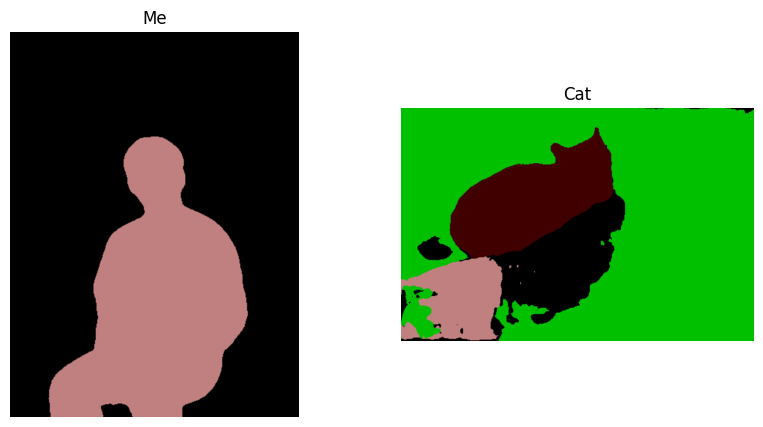

In [49]:
# 1행 2열의 서브 플롯 생성
fig, axes = plt.subplots(1, 2, figsize=(10, 5)) 

#BGR에서 RGB로 채널 변경하고 출력하기
axes[0].imshow(cv2.cvtColor(output_me, cv2.COLOR_BGR2RGB))
axes[0].set_title("Me")
axes[0].axis("off")  # 축 제거

axes[1].imshow(cv2.cvtColor(output_cat, cv2.COLOR_BGR2RGB))
axes[1].set_title("Cat")
axes[1].axis("off")

plt.show()

### 1-5. 마스크 만들기

In [50]:
#pascalvoc dataset의 label들
LABEL_NAMES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike','person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

In [51]:
#cat과 사람의 lable 확인
print("Index 8:", LABEL_NAMES[8])
print("Index 15:", LABEL_NAMES[15])

Index 8: cat
Index 15: person


In [52]:
#segvalues_me에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues_me['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [53]:
#segvalues_cat에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues_cat['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat
person
sofa


In [54]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

#cat과 person의 컬러맵 확인
print("Cat:",  colormap[8])
print("Person:", colormap[15]) 

Cat: [64  0  0]
Person: [192 128 128]


(4032, 3024)


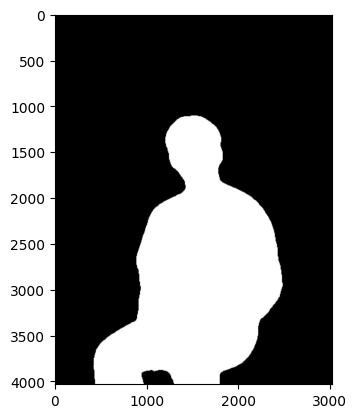

In [13]:
# 앞서 출력한 Person의 컬러맵 이용하기
seg_color_person = (128,128,192) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map_me = np.all(output_me==seg_color_person, axis=-1) 
print(seg_map_me.shape) 
plt.imshow(seg_map_me, cmap='gray')
plt.show()

(589, 890)


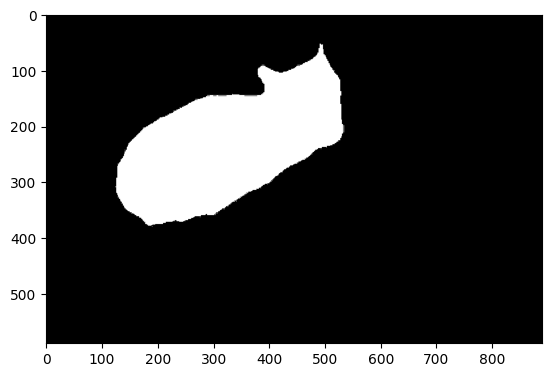

In [14]:
# 앞서 출력한 cat의 컬러맵 이용하기
seg_color_cat = (0,0,64) # 색상순서 변경 

seg_map_cat = np.all(output_cat==seg_color_cat, axis=-1) 
print(seg_map_cat.shape) 
plt.imshow(seg_map_cat, cmap='gray')
plt.show()

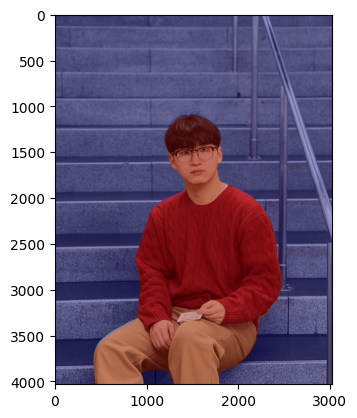

In [15]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = me.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask_me = seg_map_me.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask_me = cv2.applyColorMap(img_mask_me, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask_me, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

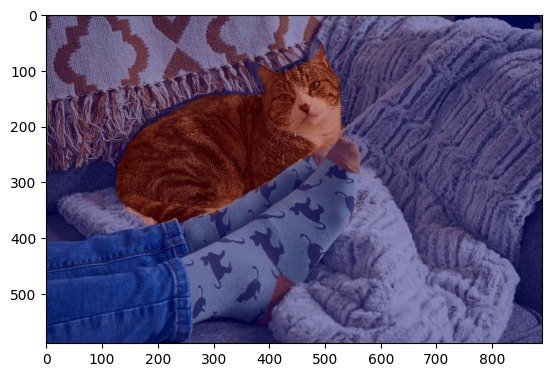

In [16]:
# 같은 과정을 cat 이미지에도 적용
img_show_cat = cat.copy()

img_mask_cat = seg_map_cat.astype(np.uint8) * 255

color_mask_cat = cv2.applyColorMap(img_mask_cat, cv2.COLORMAP_JET)

img_show_cat = cv2.addWeighted(img_show_cat, 0.6, color_mask_cat, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show_cat, cv2.COLOR_BGR2RGB))
plt.show()

### 1-6. 배경 흐리게 하기

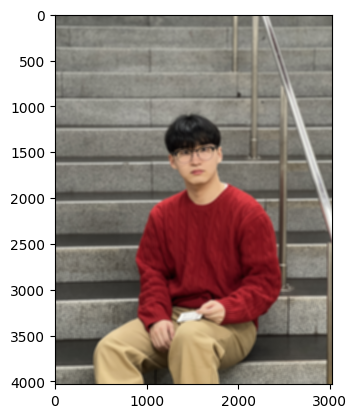

In [17]:
# 고해상도 이미지라 31*31로 블러
img_me_blur = cv2.blur(me, (31,31))

# 블러한 이미지 출력
plt.imshow(cv2.cvtColor(img_me_blur, cv2.COLOR_BGR2RGB))
plt.show()

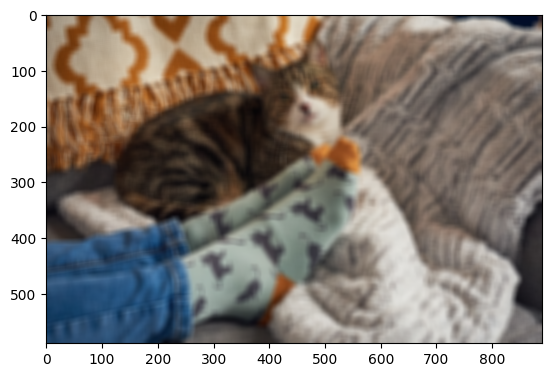

In [18]:
# 상대적으로 저해상도라 13*13로 블러
img_cat_blur = cv2.blur(cat, (13,13))

# 블러한 이미지 출력
plt.imshow(cv2.cvtColor(img_cat_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 1-7. 흐려진 이미지에서 배경만 추출하기

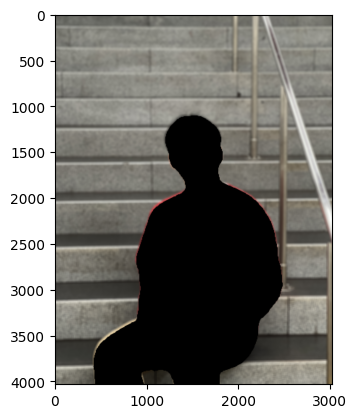

In [19]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color_me = cv2.cvtColor(img_mask_me, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color_me)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur_me = cv2.bitwise_and(img_me_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur_me, cv2.COLOR_BGR2RGB))
plt.show()

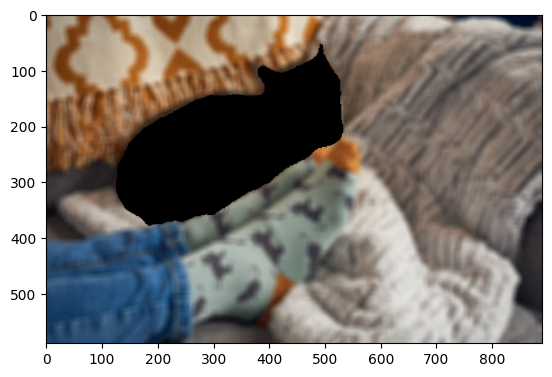

In [20]:
# 같은 과정을 cat 사진에도 적용
img_mask_color_cat = cv2.cvtColor(img_mask_cat, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color_cat)

img_bg_blur_cat = cv2.bitwise_and(img_cat_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur_cat, cv2.COLOR_BGR2RGB))
plt.show()

### 1-8. 배경과 인물 사진 합치기

(-0.5, 889.5, 588.5, -0.5)

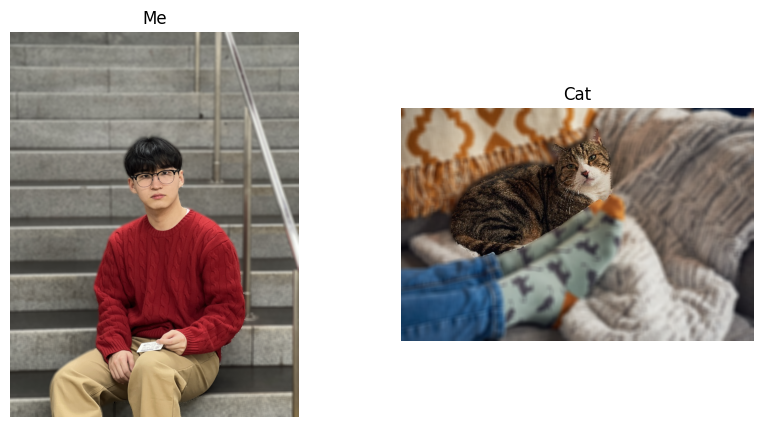

In [38]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.

portrait_me = np.where(img_mask_color_me==255, me, img_bg_blur_me)
portrait_cat = np.where(img_mask_color_cat==255, cat, img_bg_blur_cat)

fig, axes = plt.subplots(1, 2, figsize=(10, 5)) 

#BGR에서 RGB로 채널 변경하고 출력하기
axes[0].imshow(cv2.cvtColor(portrait_me, cv2.COLOR_BGR2RGB))
axes[0].set_title("Me")
axes[0].axis("off")  # 축 제거

axes[1].imshow(cv2.cvtColor(portrait_cat, cv2.COLOR_BGR2RGB))
axes[1].set_title("Cat")
axes[1].axis("off")

### 1-9. 크로마키 배경 합성
1. 배경이미지를 합성하고자하는 원본 이미지에 맞추어 해상도를 맞춰준다. cv2.resize() 이용
2. 이전에 만들어놓은 마스크를 이용하여, np.where() 을 통해 배경 합성

In [35]:
# me의 해상도 가져오기
height, width = me.shape[:2]

# bg을 me의 크기로 변경
resized_bg = cv2.resize(bg, (width, height))

(-0.5, 3023.5, 4031.5, -0.5)

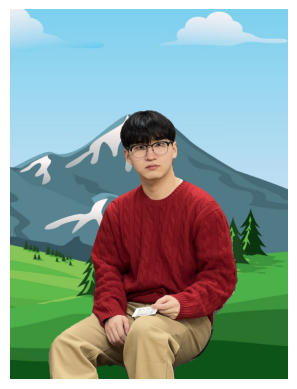

In [36]:
#np.where()을 이용하여 이미지 합성
me_bg = np.where(img_mask_color_me==255, me, resized_bg)

plt.imshow(cv2.cvtColor(me_bg, cv2.COLOR_BGR2RGB))
plt.axis("off")  # 축 제거

## Step 2 문제점 찾기

1. 인물사진에서 머리카락 같은 부분을 잘 구분하지 못해 경계부분이 모호하다
2. 기존 마스킹 방식으로는, 사람과 붙어 있는 물체를 segmantation 했을 때, 자연스럽지 않게 인물만 분리함

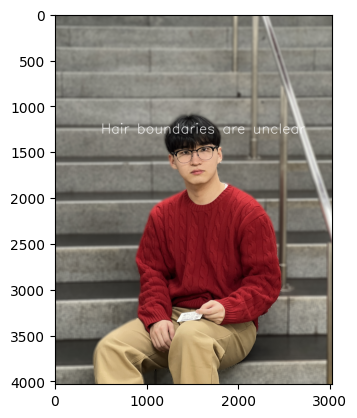

In [39]:
# 2. 텍스트 정보 설정
text = "Hair boundaries are unclear"   # 추가할 텍스트
position = (500, 1300)              # 텍스트가 출력될 위치 (x, y)
font = cv2.FONT_HERSHEY_SIMPLEX  # 폰트 설정 (다른 옵션: FONT_HERSHEY_PLAIN, FONT_HERSHEY_DUPLEX 등)
font_scale = 5                 # 폰트 크기
color = (255, 255, 255)              # 텍스트 색상 (B, G, R 형식으로 빨간색)
thickness = 5                  # 텍스트 두께

# 3. 텍스트를 이미지에 추가
cv2.putText(portrait_me, text, position, font, font_scale, color, thickness, cv2.LINE_AA)

plt.imshow(cv2.cvtColor(portrait_me, cv2.COLOR_BGR2RGB))

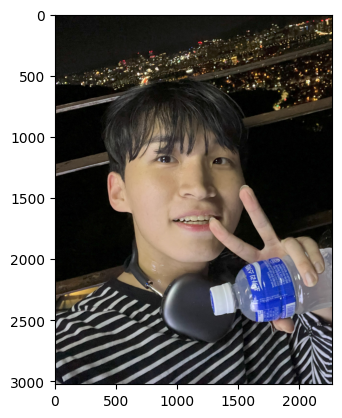

In [56]:
#os.path.join이용해서 각 이미지 경로 만들어 주기
img_path_me_2 = os.path.join(img_dir, "me_2.jpg")

me_2 = cv2.imread(img_path_me_2)
plt.imshow(cv2.cvtColor(me_2, cv2.COLOR_BGR2RGB))

In [42]:
#segmantation할 me_2이미지를 Pascalvoc 데이터셋으로 사전학습된 모델에 입력
segvalues_me_2, output_me_2 = model.segmentAsPascalvoc(img_path_me_2)

(3024, 2268)


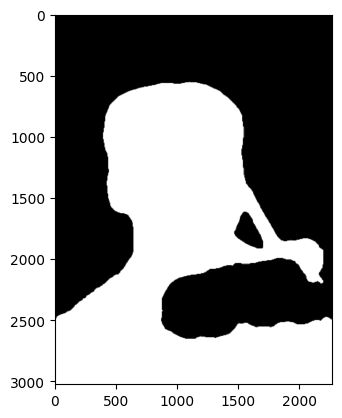

In [55]:
seg_color_person = (128,128,192) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map_me_2 = np.all(output_me_2==seg_color_person, axis=-1) 
print(seg_map_me_2.shape) 
plt.imshow(seg_map_me_2, cmap='gray')
plt.show()

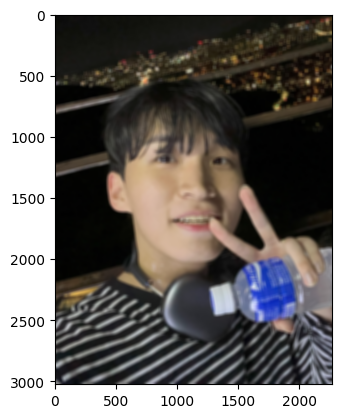

In [57]:
# 고해상도 이미지라 31*31로 블러
img_me_2_blur = cv2.blur(me_2, (31,31))

# 블러한 이미지 출력
plt.imshow(cv2.cvtColor(img_me_2_blur, cv2.COLOR_BGR2RGB))
plt.show()

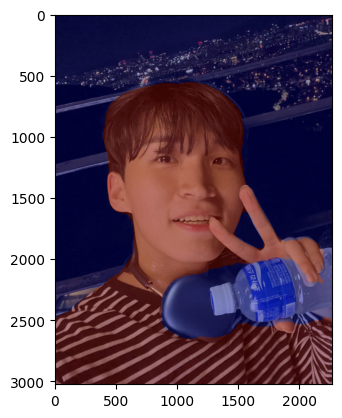

In [59]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = me_2.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask_me_2 = seg_map_me_2.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask_me_2 = cv2.applyColorMap(img_mask_me_2, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask_me_2, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

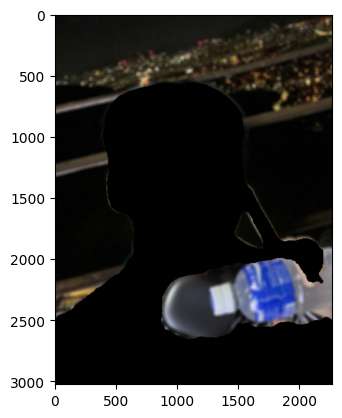

In [ ]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color_me_2 = cv2.cvtColor(img_mask_me_2, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask_2 = cv2.bitwise_not(img_mask_color_me_2)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur_me_2 = cv2.bitwise_and(img_me_2_blur, img_bg_mask_2)
plt.imshow(cv2.cvtColor(img_bg_blur_me_2, cv2.COLOR_BGR2RGB))
plt.show()

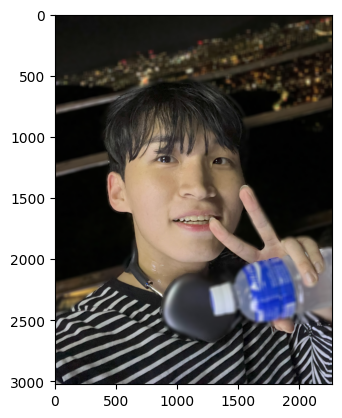

In [73]:
portrait_me_2 = np.where(img_mask_color_me_2==255, me_2, img_bg_blur_me_2)
plt.imshow(cv2.cvtColor(portrait_me_2, cv2.COLOR_BGR2RGB))

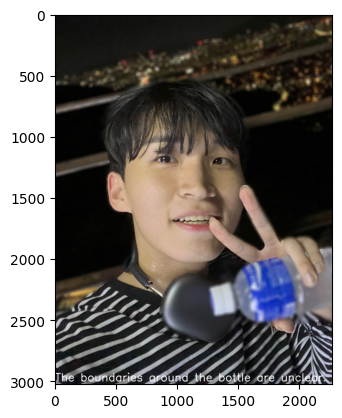

In [74]:
# 2. 텍스트 정보 설정
text = "The boundaries around the bottle are unclear."   # 추가할 텍스트
position = (0, 3000)              # 텍스트가 출력될 위치 (x, y)
font = cv2.FONT_HERSHEY_SIMPLEX  # 폰트 설정 (다른 옵션: FONT_HERSHEY_PLAIN, FONT_HERSHEY_DUPLEX 등)
font_scale = 3                # 폰트 크기
color = (255, 255, 255)              # 텍스트 색상 (B, G, R 형식으로 빨간색)
thickness = 5                  # 텍스트 두께

# 3. 텍스트를 이미지에 추가
cv2.putText(portrait_me_2, text, position, font, font_scale, color, thickness, cv2.LINE_AA)
plt.imshow(cv2.cvtColor(portrait_me_2, cv2.COLOR_BGR2RGB))


### Step 3. 해결방법을 제안해 보기

1. 머리카락 주변의 경계가 이상하게 나오는 것은 모델의 성능을 올리는 것 이외에는 크게 따로 떠오르지 않는다. blur 정도를 줄이면, 좀 더 자연스럽게 표현될 것 같다
2. 두번째 사진에서 손 주변의 물병을 segmantaion하여 사진에서 물병 주변이 blur 되어 인물 모드가 자연스럽지 않은 것은, 사람이 들고 있는 사물까지 마스크를 씌워서 인물 모드를 만들면 자연스러워 질 것 같다.

### 회고

- segmantation task를 처음 진행해봐서 흥미로웠다. OpenCV에 대해서 좀 더 공부해 보고 싶다는 생각을 하게 되었다.
- 자연스러운 결과물을 얻기 위해서는 모델의 성능이 생각보다 더 중요하다는 것을 깨달았다.